In [1]:
# import ROOT
import numpy as np
from glob import glob
import math
import matplotlib.pyplot as plt
import json
import sys

from ROOT import TCanvas, TH1F,TH2F,TH3F, TH1I, TFile,TLine,TGraph, TGraph2D, TGraphErrors, gStyle, THStack
from ROOT import TLatex, gPad, TLegend
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
# import tensorflow

sys.path.insert(1, '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/')

from functionsHelper import *


Welcome to JupyROOT 6.26/04


# Load datasets

In [5]:
# MC
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/file002.npz' 
# dataset     = np.load(filename,allow_pickle=True) # npz file contains arrays of dicts.

# Data
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/dataMinBias001.npz'
# filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/dataTest_dataMinBias001.npz'
filename    = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/dataMinBias/data_dataMinBias002.npz'
# dataset     = np.load(filename, allow_pickle=True)
dataset     = np.load(filename, allow_pickle=True)


# Helper
path        = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/'
fDict       = open(path+'dictCaloByLayer.json')
caloDict    = json.load(fDict)

print("dataset load succesfully.")

dataset load succesfully.


# Function helpers

In [6]:
def correctPhi(phi):
    '''
    Return the corrected value of _phi, inside the [-Pi,+Pi] range.
    '''
    phi = round(phi, 4)
    if (phi) < ((-1)*math.pi):
        return round(((phi) + 2*math.pi), 4)
    elif (phi) > math.pi:
        return round(((phi) - 2*math.pi), 4)
    else:
        return round((phi), 4)
    
def getMatchedIndexes(theList, matchValue):
    matched_indexes = []
    i               = 0
    
    while i < len(theList):
        if matchValue == theList[i]:
            matched_indexes.append(i)
        i+=1
    return matched_indexes

def getCellsInWindow(cellEneList, 
                     cellIndexList, 
                     cellEtaList, 
                     cellPhiList, 
                     cellSamplingList, 
                     etaSize, 
                     phiSize, 
                     layer='EMB2',
                     fullCluster=False):
   
    # get the hot cell pos and value (for the layer)
    # layerIndexes    = np.where(cellSamplingList[0][:] == layer)[0]
    layerIndexes      = getMatchedIndexes(cellSamplingList[0], layer)
    
    if fullCluster == True:
        return layerIndexes
    
    # print(cellSamplingList[0][:], layerIndexes)
    if np.size( layerIndexes ) == 0:
        return [], []
    
    hotCellValue    = np.max(np.array(cellEneList[0])[layerIndexes])
    hotCellPos      = np.argmax(np.array(cellEneList[0])[layerIndexes])
    
    window          = [] # list of indexes of the cells inside the chosen window
    
    # find cells within limits of eta phi window
    # for sampling, ind, eta, phi in zip(cellSamplingList, cellIndexList[0], cellEtaList[0], cellPhiList[0]):
    for ind, eta, phi in zip(layerIndexes, np.array(cellEtaList[0])[layerIndexes], np.array(cellPhiList[0])[layerIndexes]):
        # print(cellEtaList[0][hotCellPos])
        # print (sampling)
        # if sampling == layer:
        etaConditionL    = eta >= (cellEtaList[0][hotCellPos] - etaSize/2)
        etaConditionR    = eta <= (cellEtaList[0][hotCellPos] + etaSize/2)
        phiConditionU    = phi >= correctPhi( (cellPhiList[0][hotCellPos] - phiSize/2) )
        phiConditionD    = phi <= correctPhi( (cellPhiList[0][hotCellPos] + phiSize/2) )
        
        # print(etaConditionL,etaConditionR,phiConditionU,phiConditionD)
        
        if etaConditionL and etaConditionR and phiConditionU and phiConditionD:
            window.append( ind ) # add them to a list of index cells
            # print('window: ',window)
        
    # return the indexes of the array of cells. This array is composed of a sub-array of the cluster, with only the cells of the selected layer.
    # window        : set of positional index inside sub-array, which belongs to the window
    # layerIndexes  : array of indexes of all cells from chosen layer.
    return window, layerIndexes

def getNBinsSamplingCluster(eta, phi, sampl, clusterDict):
    '''
    Return the number of bins of TH2F for eta and phi,
    depending of the sampling.
    obs.: its a rough approximation, depending on the size of the cluster window eta-phi.
    '''
    layIdx          = getMatchedIndexes(clusterDict["Layer"], sampl)[0]
    # print(layIdx,np.shape(layIdx))
    lowEtaBounds    = clusterDict["etaLowLim"][layIdx]
    highEtaBounds   = clusterDict["etaHighLim"][layIdx]
    granEta         = clusterDict["granularityEtaLayerPrecise"][layIdx]
    granPhi         = clusterDict["granularityPhiLayerPrecise"][layIdx]
    
    etaGrid         = []
    phiGrid         = []
    
    #positive
    for stepEta, stepPhi, lowBound, highBound in zip(granEta, granPhi, lowEtaBounds, highEtaBounds):
        etaGrid.append( np.arange( lowBound, highBound, stepEta ) )
        phiGrid.append( np.arange( 0, math.pi, stepPhi ) )
    
    #add negative part to Eta/Phi
    fullEtaGrid = np.concatenate( (-1*np.flip(np.concatenate(etaGrid)[1:]), np.concatenate(etaGrid)), axis=0 )
    fullPhiGrid = np.concatenate( (-1*np.flip(np.concatenate(phiGrid)[1:]), np.concatenate(phiGrid)), axis=0 )
    
    #get NBins
    etaBins = 0
    phiBins = 0
    
    etaBins = ((np.min(eta) < fullEtaGrid) & (fullEtaGrid < np.max(eta))).sum() +1
    phiBins = ((np.min(phi) < fullPhiGrid) & (fullPhiGrid < np.max(phi))).sum() +1
    
    return int(etaBins), int(phiBins), fullEtaGrid, fullPhiGrid
    

# def plotCluster(eta, phi, layer, clusterDict):
#     layIdx          = getMatchedIndexes(clusterDict["Layer"], layer)[0]
#     # print(layIdx,np.shape(layIdx))
#     lowEtaBounds    = clusterDict["etaLowLim"][layIdx]
#     highEtaBounds   = clusterDict["etaHighLim"][layIdx]
#     granEta         = clusterDict["granularityEtaLayerPrecise"][layIdx]
#     granPhi         = clusterDict["granularityPhiLayerPrecise"][layIdx]
    
#     etaGrid         = []
#     phiGrid         = []
    
#     #positive
#     for stepEta, stepPhi, lowBound, highBound in zip(granEta, granPhi, lowEtaBounds, highEtaBounds):
#         etaGrid.append( np.arange( lowBound, highBound, stepEta ) )
    
#     #add negative part to Eta
#     fullEtaGrid = np.concatenate( (-1*np.flip(np.concatenate(etaGrid)[1:]), np.concatenate(etaGrid)), axis=0 )

#     fullPhiGrid = np.concatenate( phiGrid.append( np.arange( -1*math.pi, math.pi, stepPhi ) ) )
#     print(np.shape(fullPhiGrid), print(fullPhiGrid))
    
#     return fullEtaGrid, fullPhiGrid
    # return 0
    
# def plotCluster():
    
# eta_list=[]
# phi_list=[]
# et_list=[]

# for i,eta in enumerate(jets_roi['eta']):
#     eta_list.append(eta)
# for i,phi in enumerate(jets_roi['phi']):
#     phi_list.append(phi)
# for i,et in enumerate(jets_roi['et']/1000):
#     et_list.append(et)

# c_cell =  TCanvas("Rp","Rp Title",600,400)
# hist_rp = TH2F("hist_rp", "Rp Units EM1 - JF17",16,np.min(eta_list),np.max(eta_list),16,np.min(phi_list),np.max(phi_list))
# hist_rp.SetTitle("Jets;#eta;#phi;E_{T} [GeV]")

# for ind,index in enumerate(eta_list):
#     hist_rp.Fill(eta_list[ind],phi_list[ind],et_list[ind])

# hist_rp.Draw("LEGO2")    

# c_cell.Draw()


## Loop over events and check them

In [7]:
# dataset['dataset'][0]['electrons']['el_0']['clusters']['cl_0']['channels']['digits']
el_thr           = 15 # GeV
fullSamplingPlot = False
# sampl = 'EMB2'

evtn       = 0
plots      = []
clusSize   = {key:[] for key in caloDict["Layer"]}
clusSizeCh = {key:[] for key in caloDict["Layer"]}
clusSizeDigitsVsRawCh   = {"digits": {key:[] for key in caloDict["Layer"]}, "rawChannels":{key:[] for key in caloDict["Layer"]}}



for ev in dataset['dataset']: # for each event...
    if (evtn%1000) == 0:
        print("Electron {}...".format(evtn))
        
    tempClusSizeCh = {key:[] for key in caloDict["Layer"]}
    tempClusSize   = {key:[] for key in caloDict["Layer"]}
    tempClusSizeDigits   = {key:[] for key in caloDict["Layer"]}
    tempClusSizeRawCh   = {key:[] for key in caloDict["Layer"]}


    
#     if evtn > 100:
#         break
    for elec in ev['electrons'].keys(): # for each electron in this event...
#         print(ev['electrons'][elec]['pt'])
        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            continue
        for clus in ev['electrons'][elec]['clusters'].keys(): # for each cluster associated to that electron...

            if np.abs(ev['electrons'][elec]['clusters'][clus]["eta"][0]) > 1.4:
                continue
                
            for sampl in caloDict["Layer"]:
                windowIndexesCh, layerIndexesCh = getCellsInWindow(
                    ev['electrons'][elec]['clusters'][clus]['channels']['energy'],
                    ev['electrons'][elec]['clusters'][clus]['channels']['index'],
                    ev['electrons'][elec]['clusters'][clus]['channels']['eta'],
                    ev['electrons'][elec]['clusters'][clus]['channels']['phi'],
                    ev['electrons'][elec]['clusters'][clus]['channels']['sampling'],
                    .125, #size in eta
                    .125, #size in phi
                    sampl
                )
                
                layerIndexes = getMatchedIndexes(
                    ev['electrons'][elec]['clusters'][clus]['cells']['sampling'][0], 
                    sampl)
                
#                 (sampl=='PreSamplerB') or (sampl=='EMB1') or (sampl=='EMB2') or (sampl=='EMB3') ) and 
                if len(layerIndexes) == 0:
#                 print(" layerIndexes size = 0 for {}".format(sampl))
#                 print(" ", ev['electrons'][elec]['clusters'][clus]['pt'], " " )
#                 print(np.array( ev['electrons'][elec]['clusters'][clus]['cells']['eta'][0]) [layerIndexes] )
                    continue
#                 

                # Full cluster in each sampling
                etaLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['eta'][0])[layerIndexesCh]
                phiLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['phi'][0])[layerIndexesCh]
                eneLayerCh    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[layerIndexesCh]/1000
                digitsColl    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[layerIndexesCh]
                
                etaLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['eta'][0])[layerIndexes]
                phiLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['phi'][0])[layerIndexes]
#                 eneLayer    = np.array(ev['electrons'][elec]['clusters'][clus]['cells']['energy'][0])[layerIndexes]/1000

                rawChAmpl    = np.array(ev['electrons'][elec]['clusters'][clus]['rawChannels']['amplitude'][0])[layerIndexes]
                
                # reduced window at each sampling
                etaWindow   = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['eta'][0])[windowIndexesCh]
                phiWindow   = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['phi'][0])[windowIndexesCh]
                eneWindow    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['energy'][0])[windowIndexesCh]/1000
                
                #####################
                
                # size of cluster
                tempClusSize[sampl].append(len(etaLayer))
                tempClusSizeDigits[sampl].append(len(digitsColl))
                tempClusSizeRawCh[sampl].append(len(rawChAmpl))

#                 clusSize[sampl].append(len(etaLayer))
                
                if evtn < 0:
                    # Get number of bins
                    etabins, phibins, etaGrid, phiGrid = getNBinsSamplingCluster(etaLayer, phiLayer, sampl, caloDict)

                    # Plot TH2F of cluster #
                    c_cell =  TCanvas("Cells_Evt{}_{}".format(evtn,clus),"{}_ev{}_{}".format(sampl, evtn, clus),600,400)
                    if fullSamplingPlot:
                        hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),len(etaGrid),np.min(etaGrid),np.max(etaGrid),len(phiGrid),np.min(phiGrid),np.max(phiGrid))
                    else:
                        hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),etabins,np.min(etaLayer),np.max(etaLayer),phibins,np.min(phiLayer),np.max(phiLayer))
                    hist_clus.SetTitle("Zee;#eta;#phi;E_{T} [GeV]")

                    for ind,index in enumerate(etaLayer):
                        hist_clus.Fill(etaLayer[ind],phiLayer[ind],eneLayer[ind])

                    hist_clus.Draw("LEGO2")    

                    c_cell.Draw()
                    c_cell.Print("Plots/{}_ev{}_{}.png".format(sampl, evtn, clus))
                ####################
    for key in clusSize.keys():
        clusSize[key].append(sum(tempClusSize[key]))
        clusSizeDigitsVsRawCh["digits"][key].append(sum(tempClusSizeDigits[key]))
        clusSizeDigitsVsRawCh["rawChannels"][key].append(sum(tempClusSizeRawCh[key]))
    evtn+=1 

Electron 0...
Electron 1000...


/tmp/ipykernel_754/2005739420.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digitsColl    = np.array(ev['electrons'][elec]['clusters'][clus]['channels']['digits'][0])[layerIndexesCh]


Electron 2000...
Electron 3000...
Electron 4000...
Electron 5000...


## Cluster Size

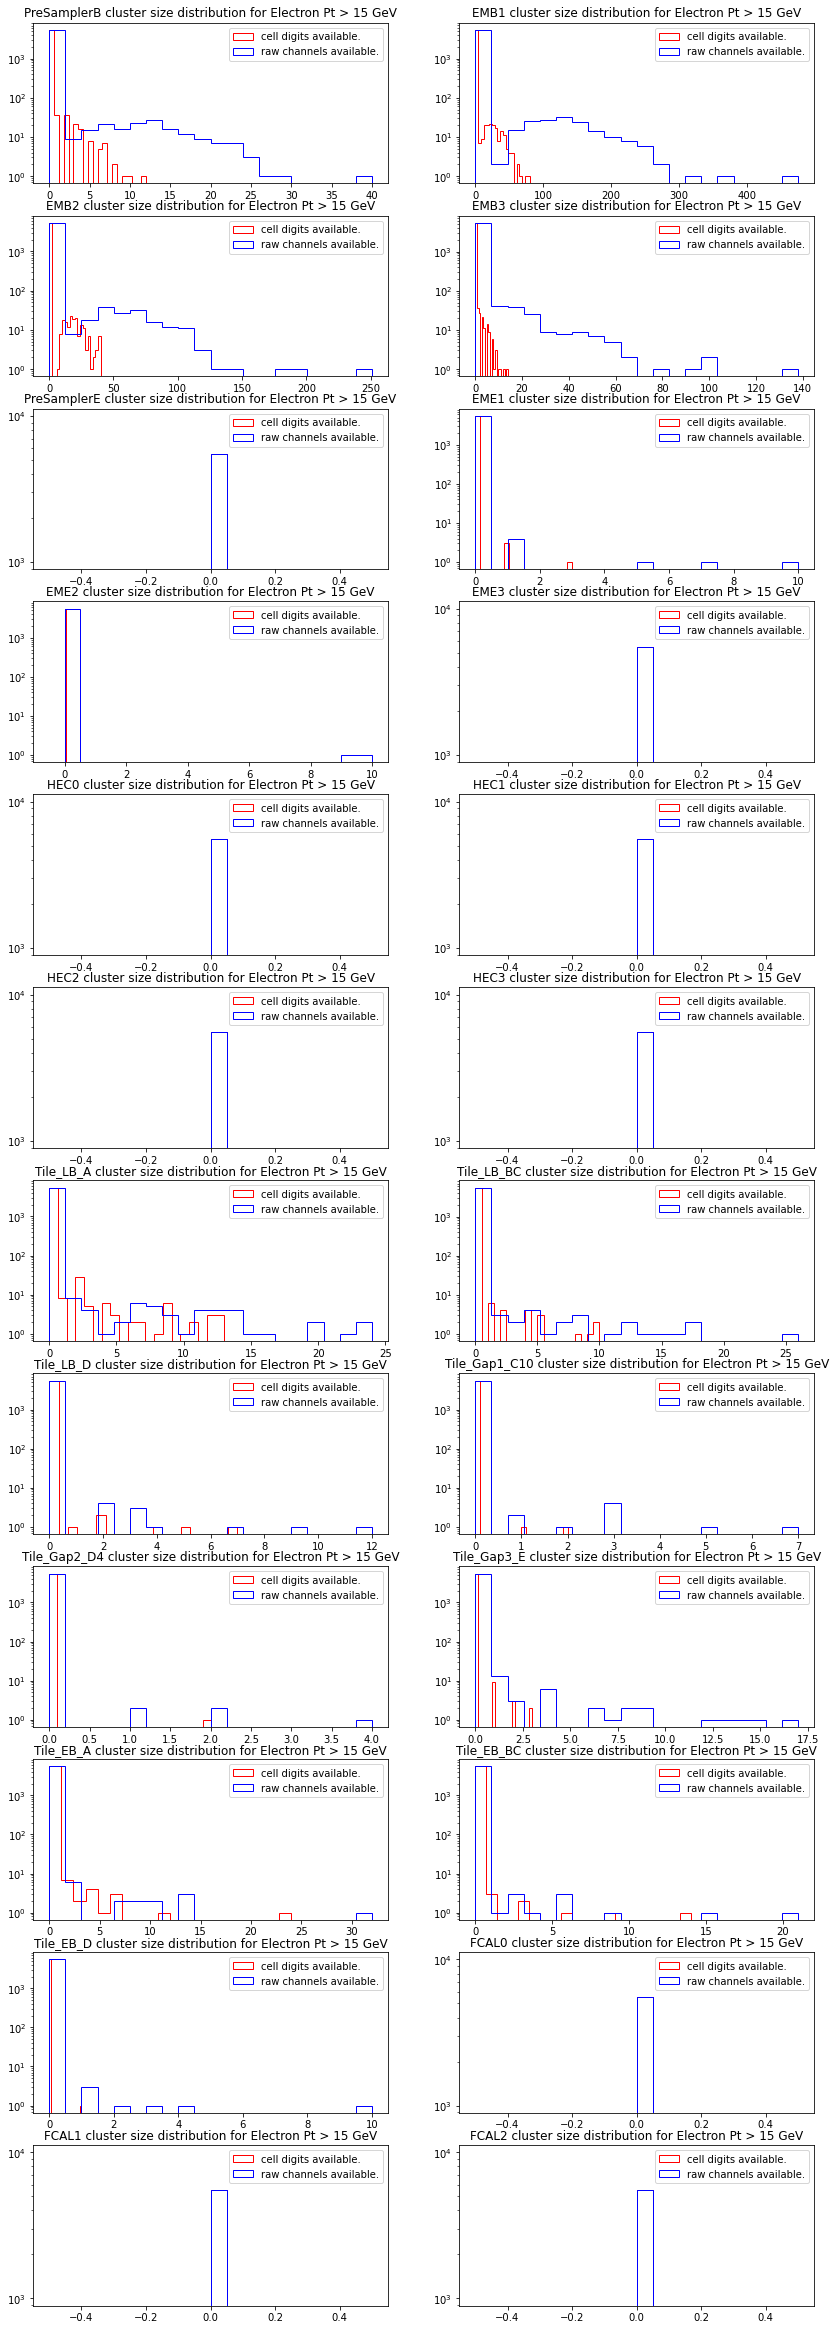

In [8]:
plt.figure(figsize=(14,42))
for i,key in enumerate(list(clusSizeDigitsVsRawCh["digits"].keys())):
    plt.subplot(12,2,i+1)
    
    plt.hist(clusSizeDigitsVsRawCh["digits"][key],bins=20,histtype='step',color='red', label='cell digits available.')
    plt.hist(clusSizeDigitsVsRawCh["rawChannels"][key],bins=20,histtype='step',color='blue', label='raw channels available.')

    plt.title("{} cluster size distribution for Electron Pt > {} GeV".format(key, el_thr))
#     plt.xlabel("Number of cells")
    plt.yscale("log")
    plt.legend()
plt.show()

In [60]:
plt.figure(figsize=(14,14))
for i,key in enumerate(list(clusSize.keys())[0:4]):
    plt.subplot(2,2,i+1)
    plt.hist(clusSize[key],bins=100)
    print(min(clusSize[key]))
    plt.title("{} cluster size distribution".format(key))
    plt.xlabel("Number of cells")
    plt.yscale("log")
plt.show()

0
0
0
0


## Debug size of clusters

In [6]:
# inputFilesPath  = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/ntuples/test_MCZee.root'
inputFilesPath  = '/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/ntuples/test_minbias_clusSize.root'
inputFileName   = glob('{}'.format(inputFilesPath))

sTree = ROOT.TChain("dumpedData",'')

for file in inputFileName:
    fileNameInputLog = file+" added to the TChain..."
    print(fileNameInputLog)  
    sTree.Add(file+"/dumpedData")
    
nEvts = sTree.GetEntries()
evLim = nEvts
dictCaloLayer = caloDict

clusSize_preDataset = {key:[] for key in range(0, len(caloDict["Layer"]))}
datasetDict = {"dataset": []}

for evN in range(0,evLim):
    if evN >= evLim:
        break
    sTree.GetEntry(evN)
    if (evN % 500) == 0:
        evtLogInfo = "Event %d / %d"%(evN, evLim)
#         timePerEvStart = time()

        print(evtLogInfo)
        # logging.info(evtLogInfo)
    
    ei_runNumber    = int(getattr(sTree, "RunNumber"))
    ei_eventNumber  = int(getattr(sTree, "EventNumber"))
    ei_bcid         = int(getattr(sTree, "BCID"))
    ei_avgMu        = getattr(sTree, "avg_mu")

    # print(ei_eventNumber, type(ei_eventNumber),int(ei_eventNumber), np.int64(ei_eventNumber))

    electronPt                  = getattr(sTree,'el_Pt')
    electronIndex               = getattr(sTree,'el_index')
    electronIndex_clusterLvl    = getattr(sTree,'c_electronIndex_clusterLvl')
    electronEta                 = getattr(sTree,'el_Eta')
    electronPhi                 = getattr(sTree,'el_Phi')
    electronEoverP              = getattr(sTree,'el_eoverp')
    electronSSf1                = getattr(sTree,'el_f1')
    electronSSf3                = getattr(sTree,'el_f3')
    electronSSeratio            = getattr(sTree,'el_eratio')
    electronSSweta1             = getattr(sTree,'el_weta1')
    electronSSweta2             = getattr(sTree,'el_weta2')
    electronSSfracs1            = getattr(sTree,'el_fracs1')
    electronSSwtots1            = getattr(sTree,'el_wtots1')
    electronSSe277              = getattr(sTree,'el_e277')
    electronSSreta              = getattr(sTree,'el_reta')
    electronSSrphi              = getattr(sTree,'el_rphi')
    electronSSdeltae            = getattr(sTree,'el_deltae')
    electronSSrhad              = getattr(sTree,'el_rhad')
    electronSSrhad1             = getattr(sTree,'el_rhad1')

    clusterIndex                 = getattr(sTree,'cluster_index')
    clusterPt                    = getattr(sTree,'cluster_pt')
    clusterEta                   = getattr(sTree,'cluster_eta')
    clusterPhi                   = getattr(sTree,'cluster_phi')
    # clusterEtaCalc               = getattr(sTree,'cluster_eta_calc')
    # clusterPhiCalc               = getattr(sTree,'cluster_phi_calc')
    # Cluster Cells 
    clusterCellIndex             = getattr(sTree,'cluster_cell_index') 
    clusterIndexCellLvl          = getattr(sTree,'cluster_index_cellLvl')
    clusterCellCaloGain          = getattr(sTree,'cluster_cell_caloGain')
    clusterCellLayer             = getattr(sTree,'cluster_cell_layer')
    clusterCellRegion            = getattr(sTree,'cluster_cell_region')
    clusterCellEta               = getattr(sTree,'cluster_cell_eta')
    clusterCellPhi               = getattr(sTree,'cluster_cell_phi') 
    clusterCellDEta              = getattr(sTree,'cluster_cell_deta')
    clusterCellDPhi              = getattr(sTree,'cluster_cell_dphi')
    clusterCellsDistDEta         = getattr(sTree,'cluster_cellsDist_deta')
    clusterCellsDistDPhi         = getattr(sTree,'cluster_cellsDist_dphi')
    # Cluster Channel 
    clusterIndexChLvl            = getattr(sTree,'cluster_index_chLvl')
    clusterChannelIndex          = getattr(sTree,'cluster_channel_index')
    clusterChannelDigits         = getattr(sTree,'cluster_channel_digits')
    clusterChannelEnergy         = getattr(sTree,'cluster_channel_energy')
    clusterChannelTime           = getattr(sTree,'cluster_channel_time')
#     if dataHasBadCh: clusterChannelBad            = getattr(sTree,'cluster_channel_bad')
    clusterChannelChInfo         = getattr(sTree,'cluster_channel_chInfo')
    # Cluster raw channel 
    clusterIndexRawChLvl         = getattr(sTree,'cluster_index_rawChLvl')
    clusterRawChannelIndex       = getattr(sTree,'cluster_rawChannel_index')
    clusterRawChannelAmplitude   = getattr(sTree,'cluster_rawChannel_amplitude')
    clusterRawChannelTime        = getattr(sTree,'cluster_rawChannel_time')
    clusterRawChannelPedProv     = getattr(sTree,'cluster_rawChannel_pedProv')
    clusterRawChannelQual        = getattr(sTree,'cluster_rawChannel_qual')
    clusterRawChannelChInfo      = getattr(sTree,'cluster_rawChannel_chInfo')

    #**********************************************
    # Format into python list/np array
    #**********************************************
    electronPtArray                 = stdVecToArray(electronPt)
    electronIndexArray              = stdVecToArray(electronIndex)
    electronIndex_clusterLvlArray   = stdVecToArray(electronIndex_clusterLvl)
    electronEtaArray                = stdVecToArray(electronEta)
    electronPhiArray                = stdVecToArray(electronPhi)
    electronEoverPArray             = stdVecToArray(electronEoverP)
    electronSSf1Array               = stdVecToArray(electronSSf1)
    electronSSf3Array               = stdVecToArray(electronSSf3)
    electronSSeratioArray           = stdVecToArray(electronSSeratio)
    electronSSweta1Array            = stdVecToArray(electronSSweta1)
    electronSSweta2Array            = stdVecToArray(electronSSweta2)
    electronSSfracs1Array           = stdVecToArray(electronSSfracs1)
    electronSSwtots1Array           = stdVecToArray(electronSSwtots1)
    electronSSe277Array             = stdVecToArray(electronSSe277)
    electronSSretaArray             = stdVecToArray(electronSSreta)
    electronSSrphiArray             = stdVecToArray(electronSSrphi)
    electronSSdeltaeArray           = stdVecToArray(electronSSdeltae)
    electronSSrhadArray             = stdVecToArray(electronSSrhad)
    electronSSrhad1Array            = stdVecToArray(electronSSrhad1)

    clusterIndexArray               = stdVecToArray(clusterIndex)
    clusterPtArray                  = stdVecToArray(clusterPt)
    clusterEtaArray                 = stdVecToArray(clusterEta)
    clusterPhiArray                 = stdVecToArray(clusterPhi)

    clusterCellIndexArray           = stdVecToArray(clusterCellIndex)
    clusterIndexCellLvlArray        = stdVecToArray(clusterIndexCellLvl)
    clusterCellCaloGainArray        = stdVecToArray(clusterCellCaloGain)
    clusterCellLayerArray           = stdVecToArray(clusterCellLayer)
    clusterCellRegionArray          = stdVecToArray(clusterCellRegion)
    clusterCellEtaArray             = stdVecToArray(clusterCellEta)
    clusterCellPhiArray             = stdVecToArray(clusterCellPhi)
    clusterCellDEtaArray            = stdVecToArray(clusterCellDEta)
    clusterCellDPhiArray            = stdVecToArray(clusterCellDPhi)
    clusterCellsDistDEtaArray       = stdVecToArray(clusterCellsDistDEta)
    clusterCellsDistDPhiArray       = stdVecToArray(clusterCellsDistDPhi)
    
    clusterIndexChLvlArray          = stdVecToArray(clusterIndexChLvl)
    clusterChannelIndexArray        = stdVecToArray(clusterChannelIndex)
    clusterChannelDigitsArray       = stdVecOfStdVecToArrayOfList(clusterChannelDigits, convertToInt=True)
    clusterChannelEnergyArray       = stdVecToArray(clusterChannelEnergy)
    clusterChannelTimeArray         = stdVecToArray(clusterChannelTime)
    clusterChannelChInfoArray       = stdVecOfStdVecToArrayOfList(clusterChannelChInfo)
#     if dataHasBadCh: clusterChannelBadArray      = stdVecToArray(clusterChannelBad)

    clusterIndexRawChLvlArray       = stdVecToArray(clusterIndexRawChLvl)
    clusterRawChannelIndexArray     = stdVecToArray(clusterRawChannelIndex)
    clusterRawChannelAmplitudeArray = stdVecToArray(clusterRawChannelAmplitude)
    clusterRawChannelTimeArray      = stdVecToArray(clusterRawChannelTime)
    clusterRawChannelPedProvArray   = stdVecToArray(clusterRawChannelPedProv)
    clusterRawChannelQualArray      = stdVecToArray(clusterRawChannelQual)
    clusterRawChannelChInfoArray    = stdVecOfStdVecToArrayOfList(clusterRawChannelChInfo) # problems with memory Leakage. TAKE A LOOK
    
    values = np.unique(clusterCellLayerArray).tolist()
    sizeLayers = {key:(clusterCellLayerArray).tolist().count(key) for key in values}
    
    if len(clusterCellLayerArray)==0:
        continue
    
    for key in sizeLayers.keys():
        clusSize_preDataset[key].append(sizeLayers[key])
    
#     print(clusterIndex)
#     print(clusterCellIndexArray)
#     print(np.shape(clusterCellLayerArray))
#     print(np.shape(clusterCellIndexArray))
#     print(sizeLayers)
    
# print(caloDict["Layer"])
    #**********************************************
#  XTALKS STUDIES: DATASET DICT
#**********************************************

# ----------------------- 0 EventInfo -------------------------------------
    eventInfoDict = {
        "runNumber":        [],
        "eventNumber":      [],
        "BCID":             [],
        "avgMu":            [],
        "electrons":        {}
    }
    eventInfoDict["runNumber"].append(ei_runNumber)
    eventInfoDict["eventNumber"].append(ei_eventNumber)
    eventInfoDict["BCID"].append(ei_bcid)
    eventInfoDict["avgMu"].append(ei_avgMu)
    
    # ----------------------- I Electron -------------------------------------
    if len(electronIndexArray) == 0: # skip events without electrons
        continue
    for elec in range(0, len(electronIndexArray)):
        electronDict    = {
        "el_{}".format(elec):{
            "index":      [],
            "pt":         [],
            "eta":        [],
            "phi":        [],
            "eoverp":     [],
            #shower shapes
            "f1":         [],
            "f3":         [],
            "eratio":     [],
            "weta1" :     [],
            "weta2" :     [],
            "fracs1":     [],
            "wtots1":     [],
            "e277"  :     [],
            "reta"  :     [],
            "rphi"  :     [],
            "deltae":     [],
            "rhad"  :     [],
            "rhad1" :     [],

            "clusters":{}
            }
        } # electron-end

        electronDict["el_{}".format(elec)]["index"].append(electronIndexArray[elec])
        electronDict["el_{}".format(elec)]["pt"].append(electronPtArray[elec])
        electronDict["el_{}".format(elec)]["eta"].append(electronEtaArray[elec])
        electronDict["el_{}".format(elec)]["phi"].append(electronPhiArray[elec])
        electronDict["el_{}".format(elec)]["eoverp"].append(electronEoverPArray[elec])
        electronDict["el_{}".format(elec)]["f1"].append(electronSSf1Array[elec])
        electronDict["el_{}".format(elec)]["f3"].append(electronSSf3Array[elec])
        electronDict["el_{}".format(elec)]["eratio"].append(electronSSeratioArray[elec])
        electronDict["el_{}".format(elec)]["weta1"].append(electronSSweta1Array[elec])
        electronDict["el_{}".format(elec)]["weta2"].append(electronSSweta2Array[elec])
        electronDict["el_{}".format(elec)]["fracs1"].append(electronSSfracs1Array[elec])
        electronDict["el_{}".format(elec)]["wtots1"].append(electronSSwtots1Array[elec])
        electronDict["el_{}".format(elec)]["e277"].append(electronSSe277Array[elec])
        electronDict["el_{}".format(elec)]["reta"].append(electronSSretaArray[elec])
        electronDict["el_{}".format(elec)]["rphi"].append(electronSSrphiArray[elec])
        electronDict["el_{}".format(elec)]["deltae"].append(electronSSdeltaeArray[elec])
        electronDict["el_{}".format(elec)]["rhad"].append(electronSSrhadArray[elec])
        electronDict["el_{}".format(elec)]["rhad1"].append(electronSSrhad1Array[elec])

    # ----------------------- II Calo Objects (Cluster) ----------------------
        # find array indexes for the cluster collection, from each electron.
        eIndexClus = np.where( electronIndex_clusterLvlArray == electronIndexArray[elec] )[0]

        # with the array indexes, find the the cluster indexes, linked to the selected electron
        # ( the cluster index is used to reach the cell level indexes. )
        # for cIndex in clusterIndexArray[eIndexClus]: # for each cluster
        for cl in eIndexClus:
    
            # layerIndex = np.where(clusterCellLayerArray[cIndexCell] == 2)[0] # get EMB2 cells
            clusterDict = {
                "cl_{}".format(clusterIndexArray[cl]):{
                    "index":        [],
                    "pt":           [],
                    "eta":          [],
                    "phi":          [],
                    # cells
                    "cells":         {}, # structure
                    "channels":      {}, # structure
                    "rawChannels":   {} # structure
                }
            }
            # fill clusters
            clusterDict["cl_{}".format(clusterIndexArray[cl])]["index"].append(clusterIndexArray[cl])
            clusterDict["cl_{}".format(clusterIndexArray[cl])]["pt"].append(clusterPtArray[cl])
            clusterDict["cl_{}".format(clusterIndexArray[cl])]["eta"].append(clusterEtaArray[cl])
            clusterDict["cl_{}".format(clusterIndexArray[cl])]["phi"].append(clusterPhiArray[cl])

    # ----------------------- III CaloCell and Channels ------------------
            # get cells, channels and rawChannels linked to each cluster
            clusIndexCell   = np.where( clusterIndexCellLvlArray    == clusterIndexArray[cl] )[0]
            clusIndexCh     = np.where( clusterIndexChLvlArray      == clusterIndexArray[cl] )[0]
            clusIndexRawCh  = np.where( clusterIndexRawChLvlArray   == clusterIndexArray[cl] )[0]
            # print("clusterCellIndexArray:", clusterCellIndexArray)
            # print("clusterRawChannelIndexArray",clusterRawChannelIndexArray)

            # -- Cells --
            # OBS.: it was chosen to remove most of the information in this part of dict (cell level), because
            # it is more convenient to work with the xtalk and cell data in the same level, in this case, in channel.
            cellDict    = {
                "index":        [],
                # "caloRegion":   [],
                # "sampling":     [],
                # "eta":          [],
                # "phi":          [],
                # "deta":         [],
                # "dphi":         [],
                # "gain":         []
            }
            cellRegionString    = getRegionString( clusterCellRegionArray[clusIndexCell] , dictCaloLayer["Region"])
            cellSamplingString  = getSamplingString( clusterCellLayerArray[clusIndexCell] , dictCaloLayer["Layer"] )
            cellCaloGainString  = getCaloGainString( clusterCellCaloGainArray[clusIndexCell] , dictCaloLayer["CaloGainNumber"], dictCaloLayer["CaloGainName"] )

            cellDict["index"].append( clusterCellIndexArray[clusIndexCell].tolist() )
            # cellDict["sampling"].append( cellSamplingString )
            # cellDict["caloRegion"].append( cellRegionString )
            # cellDict["eta"].append( clusterCellEtaArray[clusIndexCell].tolist() )
            # cellDict["phi"].append( clusterCellPhiArray[clusIndexCell].tolist() )
            # cellDict["deta"].append( clusterCellDEtaArray[clusIndexCell].tolist() )
            # cellDict["dphi"].append( clusterCellDPhiArray[clusIndexCell].tolist() )
            # # cellDict["gain"].append( clusterCellCaloGainArray[clusIndexCell] )
            # cellDict["gain"].append( cellCaloGainString )

            # print(clusterCellCaloGainArray[clusIndexCell], cellDict["gain"] )

            # -- Channels --
            channelDict     = {
                "index":        [],
                "caloRegion":   [], # from cell level
                "sampling":     [], # from cell level
                "energy":       [],
                "time":         [],
                "digits":       [],
                "eta":          [], # from cell level
                "phi":          [], # from cell level
                "gain":         [], # from cell level
                "deta":         [], # from cell level
                "dphi":         [], # from cell level
                "chInfo":       [] # both LAr (barrel or EC, pos or neg side, feedthrough, slot, channel) and Tile (ros, drawer, channel, adc)
            }
            roundedChIndex  = [round(x,1) for x in clusterChannelIndexArray[clusIndexCh]]
        
            channelDict["index"].append( roundedChIndex )            
            channelDict["energy"].append(clusterChannelEnergyArray[clusIndexCh].tolist())
            channelDict["time"].append(clusterChannelTimeArray[clusIndexCh].tolist())
            channelDict["digits"].append(clusterChannelDigitsArray[clusIndexCh].tolist())
            channelDict["chInfo"].append(clusterChannelChInfoArray[clusIndexCh].tolist())

            # print( np.shape(cellDict["caloRegion"]), np.shape(clusterCellRegionArray[clusIndexCell]) , np.ravel(cellDict["caloRegion"]))

            channelRegionLink       = indexConversion( channelDict["index"] , cellDict["index"], clusterCellRegionArray[clusIndexCell])
            channelSamplingLink     = indexConversion( channelDict["index"] , cellDict["index"], clusterCellLayerArray[clusIndexCell] )
            channelGainLink         = indexConversion( channelDict["index"] , cellDict["index"], clusterCellCaloGainArray[clusIndexCell] )
            channelEtaLink          = indexConversion( channelDict["index"] , cellDict["index"], clusterCellEtaArray[clusIndexCell] )
            channelPhiLink          = indexConversion( channelDict["index"] , cellDict["index"], clusterCellPhiArray[clusIndexCell] )
            channelDEtaLink         = indexConversion( channelDict["index"] , cellDict["index"], clusterCellDEtaArray[clusIndexCell] )
            channelDPhiLink         = indexConversion( channelDict["index"] , cellDict["index"], clusterCellDPhiArray[clusIndexCell] )

            channelRegionString     = getRegionString( channelRegionLink , dictCaloLayer["Region"] )
            channelSamplingString   = getSamplingString( channelSamplingLink , dictCaloLayer["Layer"])
            channelCaloGainString   = getCaloGainString( channelGainLink , dictCaloLayer["CaloGainNumber"], dictCaloLayer["CaloGainName"] )

            channelDict["caloRegion"].append( channelRegionString )
            channelDict["sampling"].append( channelSamplingString )
            channelDict["gain"].append( cellCaloGainString )
            channelDict["eta"].append (channelEtaLink.tolist() )
            channelDict["phi"].append (channelPhiLink.tolist() )
            channelDict["deta"].append(channelDEtaLink.tolist() )
            channelDict["dphi"].append(channelDPhiLink.tolist() )
            
            # # cellDict["gain"].append( clusterCellCaloGainArray[clusIndexCell] )
        
            # -- RawChannels --
            rawChannelDict  = {
                "index":        [],
                "caloRegion":   [],
                "sampling":     [],
                "amplitude":    [],
                "time":         [],
                "pedProv":      [],
                "quality":      [] # both LAr (barrel or EC, pos or neg side, feedthrough, slot, channel) and Tile (ros, drawer, channel, adc)
            }
            # must be treated because these indexes has floating point to represent tile PMT1 (+0.1) and PMT2 (+0.2), but when loading them, it is not precise (small bug to be fixed)
            roundedRawChIndex = [round(x,1) for x in clusterRawChannelIndexArray[clusIndexRawCh]]

            rawChannelDict["index"].append( roundedRawChIndex )
            rawChannelDict["amplitude"].append(clusterRawChannelAmplitudeArray[clusIndexRawCh].tolist())
            rawChannelDict["time"].append(clusterRawChannelTimeArray[clusIndexRawCh].tolist())
            rawChannelDict["pedProv"].append(clusterRawChannelPedProvArray[clusIndexRawCh].tolist())
            rawChannelDict["quality"].append(clusterRawChannelQualArray[clusIndexRawCh].tolist())

            rawChannelRegionLink        = indexConversion( rawChannelDict["index"] , cellDict["index"], clusterCellRegionArray[clusIndexCell])
            rawChannelSamplingLink      = indexConversion( rawChannelDict["index"] , cellDict["index"], clusterCellLayerArray[clusIndexCell] )
            rawChannelRegionString      = getRegionString( rawChannelRegionLink , dictCaloLayer["Region"] )
            rawChannelSamplingString    = getSamplingString( rawChannelSamplingLink , dictCaloLayer["Layer"])            

            rawChannelDict["caloRegion"].append( rawChannelRegionString )
            rawChannelDict["sampling"].append( rawChannelSamplingString )

            # df = pd.concat({k: pd.DataFrame.from_dict(v, orient='index') for k, v in rawChannelDict.items()}, axis=1)
            # print(df)
            # print(pd.concat({k: pd.DataFrame.from_dict(v) for k, v in rawChannelDict.items()}))

    # ----------------------- III-end ------------------------------------
            # fill clusters with cells, channels and raw channels
            clusName    = str("cl_{}".format(clusterIndexArray[cl]))
            clusterDict[clusName]["cells"].update( cellDict )
            clusterDict[clusName]["channels"].update( channelDict )
            clusterDict[clusName]["rawChannels"].update( rawChannelDict )

            # saveAsJsonFile(clusterDict, 'file001.json')
            # lDatasetDict = loadJsonFile('file001.json')
            # print(lDatasetDict)

            # fill electron with cluster(s)
            electronDict["el_{}".format(elec)]["clusters"].update( clusterDict ) 

        # fill event with particles
        eventInfoDict["electrons"].update( electronDict )

    # fill dataset with events
    datasetDict["dataset"].append(eventInfoDict)
    

/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/run/ntuples/test_minbias_clusSize.root added to the TChain...
Event 0 / 186107


/eos/user/m/mhufnage/scripts_lxplus/Grid/workAthena/ALPPackages/source/EventReader/share/functionsHelper.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(myArray)


Event 500 / 186107
Event 1000 / 186107
Event 1500 / 186107
Event 2000 / 186107
Event 2500 / 186107
Event 3000 / 186107
Event 3500 / 186107
Event 4000 / 186107
Event 4500 / 186107
Event 5000 / 186107
Event 5500 / 186107
Event 6000 / 186107
Event 6500 / 186107
Event 7000 / 186107
Event 7500 / 186107
Event 8000 / 186107
Event 8500 / 186107
Event 9000 / 186107
Event 9500 / 186107
Event 10000 / 186107
Event 10500 / 186107
Event 11000 / 186107
Event 11500 / 186107
Event 12000 / 186107
Event 12500 / 186107
Event 13000 / 186107
Event 13500 / 186107
Event 14000 / 186107
Event 14500 / 186107
Event 15000 / 186107
Event 15500 / 186107
Event 16000 / 186107
Event 16500 / 186107
Event 17000 / 186107
Event 17500 / 186107
Event 18000 / 186107
Event 18500 / 186107
Event 19000 / 186107
Event 19500 / 186107
Event 20000 / 186107
Event 20500 / 186107
Event 21000 / 186107
Event 21500 / 186107
Event 22000 / 186107
Event 22500 / 186107
Event 23000 / 186107
Event 23500 / 186107
Event 24000 / 186107
Event 24500 

In [13]:
# dataset['dataset'][0]['electrons']['el_0']['clusters']['cl_0']['channels']['digits']
el_thr           = 20 # GeV
fullSamplingPlot = False
# sampl = 'EMB2'

evtn     = 0
plots    = []
clusSize_beforeSave = {key:[] for key in caloDict["Layer"]}

for ev in dataset['dataset']: # for each event...
    print("Event {}...".format(evtn))
    if evtn > 50:
        break
    for elec in ev['electrons'].keys(): # for each electron in this event...
#         print(ev['electrons'][elec]['pt'])
        if ev['electrons'][elec]['pt'][0]/1000 < el_thr:
            continue
#         for clus in ev['electrons'][elec]['clusters'].keys(): # for each cluster associated to that electron...
        for clus in ev['electrons'][elec]['711_roi'].keys(): # for each cluster associated to that electron...
            # print(clus)
            # print("evt_{}".format(evtn),np.shape(ev['electrons'][elec]['clusters'][clus]['channels']['energy']))
            
            for sampl in caloDict["Layer"]:
                windowIndexes, layerIndexes = getCellsInWindow(
                    ev['electrons'][elec]['711_roi'][clus]['channels']['energy'],
                    ev['electrons'][elec]['711_roi'][clus]['channels']['index'],
                    ev['electrons'][elec]['711_roi'][clus]['channels']['eta'],
                    ev['electrons'][elec]['711_roi'][clus]['channels']['phi'],
                    ev['electrons'][elec]['711_roi'][clus]['channels']['sampling'],
                    .125, #size in eta
                    .125, #size in phi
                    sampl
                )
                if len(layerIndexes) == 0:
                    continue
#                 print(windowIndexes, layerIndexes)

                # Full cluster in each sampling
                etaLayer    = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['eta'][0])[layerIndexes]
                phiLayer    = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['phi'][0])[layerIndexes]
                eneLayer    = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['energy'][0])[layerIndexes]/1000
                
                # reduced window at each sampling
                etaWindow   = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['eta'][0])[windowIndexes]
                phiWindow   = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['phi'][0])[windowIndexes]
                eneWindow    = np.array(ev['electrons'][elec]['711_roi'][clus]['channels']['energy'][0])[windowIndexes]/1000
                
                #####################
                
                # size of cluster
                clusSize_beforeSave[sampl].append(len(etaLayer))
                
                if evtn < 50:
                
                    # Get number of bins
                    etabins, phibins, etaGrid, phiGrid = getNBinsSamplingCluster(etaLayer, phiLayer, sampl, caloDict)

                    # Plot TH2F of cluster #
                    c_cell =  TCanvas("Cells_Evt{}_{}".format(evtn,clus),"{}_ev{}_{}".format(sampl, evtn, clus),600,400)
                    if fullSamplingPlot:
                        hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),len(etaGrid),np.min(etaGrid),np.max(etaGrid),len(phiGrid),np.min(phiGrid),np.max(phiGrid))
                    else:
                        hist_clus = TH2F("{}_ev{}_{}".format(sampl, evtn, clus), "MC {} - Zee".format(sampl),etabins,np.min(etaLayer),np.max(etaLayer),phibins,np.min(phiLayer),np.max(phiLayer))
                    hist_clus.SetTitle("Zee;#eta;#phi;E_{T} [GeV]")

                    for ind,index in enumerate(etaLayer):
                        hist_clus.Fill(etaLayer[ind],phiLayer[ind],eneLayer[ind])

                    hist_clus.Draw("LEGO2")    

                    c_cell.Draw()
                    c_cell.Print("Plots/{}_ev{}_{}.png".format(sampl, evtn, clus))
                ####################

    evtn+=1 

Event 0...
Event 1...
Event 2...
Event 3...
Event 4...
Event 5...
Event 6...
Event 7...
Event 8...
Event 9...
Event 10...
Event 11...
Event 12...
Event 13...
Event 14...
Event 15...
Event 16...
Event 17...
Event 18...
Event 19...
Event 20...
Event 21...
Event 22...
Event 23...
Event 24...
Event 25...
Event 26...
Event 27...
Event 28...
Event 29...
Event 30...
Event 31...
Event 32...
Event 33...
Event 34...
Event 35...
Event 36...
Event 37...
Event 38...
Event 39...
Event 40...
Event 41...
Event 42...
Event 43...
Event 44...
Event 45...
Event 46...
Event 47...
Event 48...
Event 49...
Event 50...
Event 51...


Info in <TCanvas::Print>: png file Plots/EMB1_ev35_cl_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Cells_Evt35_cl_0
Info in <TCanvas::Print>: png file Plots/EMB2_ev35_cl_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Cells_Evt35_cl_0
Info in <TCanvas::Print>: png file Plots/PreSamplerE_ev35_cl_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Cells_Evt35_cl_0
Info in <TCanvas::Print>: png file Plots/EME1_ev35_cl_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Cells_Evt35_cl_0
Info in <TCanvas::Print>: png file Plots/EME2_ev35_cl_0.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Cells_Evt35_cl_0
Info in <TCanvas::Print>: png file Plots/Tile_EB_A_ev35_cl_0.png has been created
Info in <TCanvas::Print>: png file Plots/EMB1_ev39_cl_0.png has been created
Warning in <TCanvas::Construc

In [8]:
plt.figure(figsize=(14,14))
media = []
var   = []

for i,key in enumerate(list(clusSize.keys())[0:4]):
    plt.subplot(2,2,i+1)
    plt.hist(clusSize[key],bins=15,color='black', alpha=0.5)
    plt.title("{} cluster size distribution".format(key))
    plt.xlabel("Number of cells")
    # plt.yscale("log")
plt.show()

plt.figure(figsize=(14,14))
# for i,key,keyName in enumerate(list(clusSize_beforeSave.keys())[0:4],clusSize_preDataset.keys()):
for i,key,keyName in zip(range(0, len(list(clusSize_beforeSave.keys())))[0:4], list(clusSize_beforeSave.keys())[0:4] , list(clusSize_preDataset.keys())[0:4]):
    plt.subplot(2,2,i+1)
#     plt.hist(np.array(clusSize_beforeSave[key]),bins=15,color='r',alpha=.2)
    plt.hist(np.array(clusSize_preDataset[keyName]),bins=30,color='b',alpha=.2,label='from root file. \n{}'.format(np.mean(clusSize_preDataset[keyName])))
    plt.hist(np.array(clusSize[key]),bins=30,histtype='step',color='r', label='loaded dataset. \n{}'.format(np.mean(clusSize[key])))
    plt.title("{} cluster size distribution".format(key))
    plt.xlabel("Number of cells")
    # plt.yscale("log")
    plt.legend()
plt.show()

# plt.figure(figsize=(14,14))
# for i,key in enumerate(list(clusSize_preDataset.keys())[0:4]):
#     plt.subplot(2,2,i+1)
#     plt.hist(np.array(clusSize_preDataset[key]),bins=15)
#     plt.title("{} cluster size distribution (from dumped *.root file)".format(key))
#     plt.xlabel("Number of cells")
#     # plt.yscale("log")
# plt.show()

